In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import collections  as mc
from IPython.display import clear_output, display, Math
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
from networkx.generators.random_graphs import erdos_renyi_graph
import networkx as nx
import random
from sklearn.linear_model import LinearRegression
import math

cmap = plt.get_cmap('RdYlGn')

# Simulate the spreading of information in a network of talking nodes

## The context
Assume:
- two sources of opposite information about a topic (eg. pro-vax, no-vax)
- a network of nodes which can interact and exchange opinions regarding the topic.

We would like to analyze the evolution of this kind of system.

___

## The theory
### The mathematical framework

To do so lets define the functions, the variables and the metrics that we will use.

The most important function by far is the **opinion** function $o(n, t) \mapsto [0,1]$ that, given a node or a source of information $n$ and a timestep $t$, returns the opinion that the node has about the topic.

The network is defined as an **Erdos-Renyi Random Graph** $G(N, E)$ with edge probability $p$.

Please notice also that:
- $o(n, 0) = \frac{1}{2} \ \forall\ n \in N$
- $o(s_0, t) = 0\ \forall\ t \in \mathbb{N}$
- $o(s_1, t) = 1\ \forall\ t \in \mathbb{N}$

Each node has a **flexibility** factor $f$ that express the inclination of the indivual to change opinion, the **flexibility** has initially value $f=1$ but it decreases geometrically by a factor $\gamma=0.9$ every time opinion is updated.

### How the system evolves

Iteratively a source choose a subset of nodes and send them the information and they react changing their opinion on the topic. The amount of change is weighted by the $f$ term and the new opinion is defined via the formula 

$o(t+1) = (1-f)*o(t) + f*info$. 

At the same time we assume that a node will exchange information with some of its neighbor, doing so both the nodes ($n1, n2$), constituting an edge $e$, will change their opinion

$o(n1, t+1) = o(n2, t+1) = \frac{o(n1, t) + o(n2, t)}{2}$


### The algorithm

At each timestep the information sources $s_0, s_1$ select a random subset of the nodes and update their opinions. Each node is selected with $prob_0$ from $s_0$ and $prob_1$ from $s_1$. Let's define $Ratio = \frac{prob_1}{prob_0}$ and $prob_0$ is a baseline for the number of people a source can reach.

Subsequently, a random subset of edges is selected and the opinions of the sources and destinations of the edges are updated. Each edge is selected with $prob = 0.20$


In [2]:
def create_graph(n, p, default_opin=0.5, default_flex=1.):
    G = erdos_renyi_graph(n, p)
    for n in G.nodes:
        G.nodes[n]['o'] = default_opin
        G.nodes[n]['f'] = default_flex

    return G

def extract_node_attribute(G, attribute_name):
    return [G.nodes[n][attribute_name] for n in G.nodes]

def run_evolution(G, n_iter=200, 
                  p_node_0=.2, p_node_1=.2, p_edge=.2, gamma=.9, 
                  s_0=0., s_1=1., verbose=True):
    n_nodes = len(G.nodes)
    n_edges = len(G.edges)
    edges_list = list(G.edges)
    if verbose:
        iter_range = tqdm(range(n_iter))
    else:
        iter_range = range(n_iter)
    for i in iter_range:
        # Sources spread information
        filter_0 = np.random.rand(n_nodes) < p_node_0
        filter_1 = np.random.rand(n_nodes) < p_node_1
        filter_0 *= filter_0 != filter_1
        filter_1 *= filter_0 != filter_1
        selected_noded_0 = np.arange(n_nodes)[filter_0]
        selected_noded_1 = np.arange(n_nodes)[filter_1]
        for n in selected_noded_0:
            G.nodes[n]['o'] = (1 - G.nodes[n]['f'])*G.nodes[n]['o'] + G.nodes[n]['f']*s_0
            G.nodes[n]['f'] *= gamma
        for n in selected_noded_1:
            G.nodes[n]['o'] = (1 - G.nodes[n]['f'])*G.nodes[n]['o'] + G.nodes[n]['f']*s_1
            G.nodes[n]['f'] *= gamma

        # The nodes exchange information
        selected_edges = np.arange(n_edges)[np.random.rand(n_edges) < p_edge]
        for e_idx in selected_edges:
            n1, n2 = edges_list[e_idx]
            opinion = (G.nodes[n1]['o'] + G.nodes[n2]['o']) / 2
            G.nodes[n1]['o'] = (1 - G.nodes[n1]['f'])*G.nodes[n1]['o'] + G.nodes[n1]['f']*opinion
            G.nodes[n1]['f'] *= gamma
            G.nodes[n2]['o'] = (1 - G.nodes[n2]['f'])*G.nodes[n1]['o'] + G.nodes[n2]['f']*opinion
            G.nodes[n2]['f'] *= gamma
        if np.mean(extract_node_attribute(G, 'f')) < .01:
            break
    # Return the updated graph
    return G

## The simulation
The simulation takes all the parameters and returns the resulting graph or a dataframe containing all the usefull information

In [3]:
def run_simulation(n, p, n_iter=200, p_node_0=.2, p_node_1=.2, p_edge=.2, 
                   gamma=.9, verbose=True):
    G = create_graph(n, p)
    G = run_evolution(G, n_iter, 
                      p_node_0=p_node_0, p_node_1=p_node_1, p_edge=p_edge,
                      gamma=gamma, verbose=verbose)
    return G

def extract_info_from_simulation(n, p, n_iter=200, 
                                 p_node_0=.2, p_node_1=.2, p_edge=.2, gamma=.9):
    G = run_simulation(n, p, n_iter=n_iter,
                       p_node_0=p_node_0, p_node_1=p_node_1, p_edge=p_edge,
                       gamma=gamma, verbose=False)
    df = pd.DataFrame([G.nodes[n] for n in G.nodes])
    df['degree'] = pd.DataFrame(G.degree)[1]
    df['p_node_0'] = p_node_0
    df['p_node_1'] = p_node_1
    df['p_edge'] = p_edge
    df['gamma'] = gamma
    df['p_node_ratio'] = p_node_1 / p_node_0
    return df

def extract_info_from_multiple_simulation(n_sim, n, p, n_iter=200, 
                                 p_node_0=.2, p_node_1=.2, p_edge=.2, gamma=.9,
                                 verbose=True):
    dfs = []
    if verbose:
        iter_range = tqdm(range(n_sim))
    else:
        iter_range = range(n_sim)
    for i in iter_range:
        _df = extract_info_from_simulation(n, p, n_iter=n_iter, 
                                           p_node_0=p_node_0, p_node_1=p_node_1, 
                                           p_edge=p_edge, gamma=gamma)
        _df['idx'] = i
        dfs.append(_df)
    return pd.concat(dfs)

## The parameters


In [4]:
n = 50 # n. of nodes used in the plots
p = 0.07 # prob. of an edge in the ER-graph
n_sim = 500 # n. of simulation
n_nodes = 250 # n. of nodes used in the simulations

## A small example

### Create a Graph, run the evolution and plot the rusults



In [5]:
def plot_graph(G, ax=None):
    opinions = extract_node_attribute(G, 'o')
    labels = dict(zip(G.nodes, np.round(opinions, 1)))

    pos=nx.spring_layout(G)
    pos_higher = {}
    for k, v in pos.items():
        pos_higher[k] = (v[0], v[1])

    nx.draw(G, node_color=cmap(opinions), edge_color='#0f0f0f80', ax=ax, pos=pos, node_size=400)
    nx.draw_networkx_labels(G, pos_higher, labels, ax=ax, font_size=10, font_color='#000000')

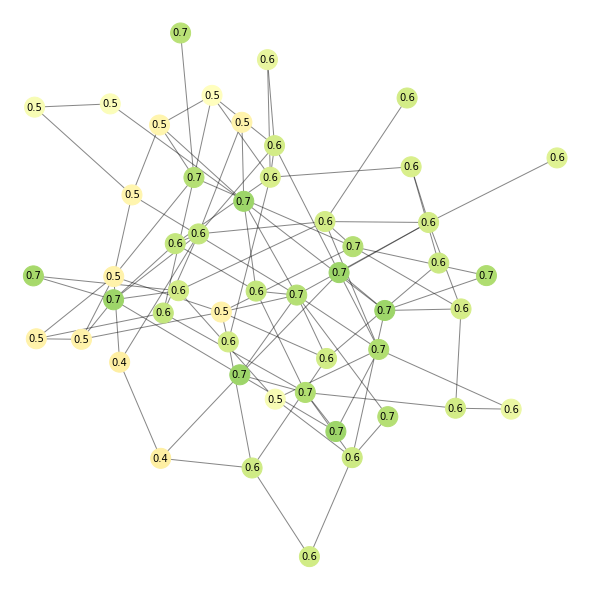

In [6]:
np.random.seed(9)
random.seed(6)
plt.figure(figsize=(8,8))
G = create_graph(n, p)
G = run_evolution(G, n_iter=200, 
                  p_node_0=.2, p_node_1=.2, p_edge=.2, gamma=.9, 
                  s_0=0., s_1=1., verbose=True)
plot_graph(G)
plt.draw() 

## Analyze results for different parameters ($Ratio, \gamma$)

### Plot the simulation of small graphs

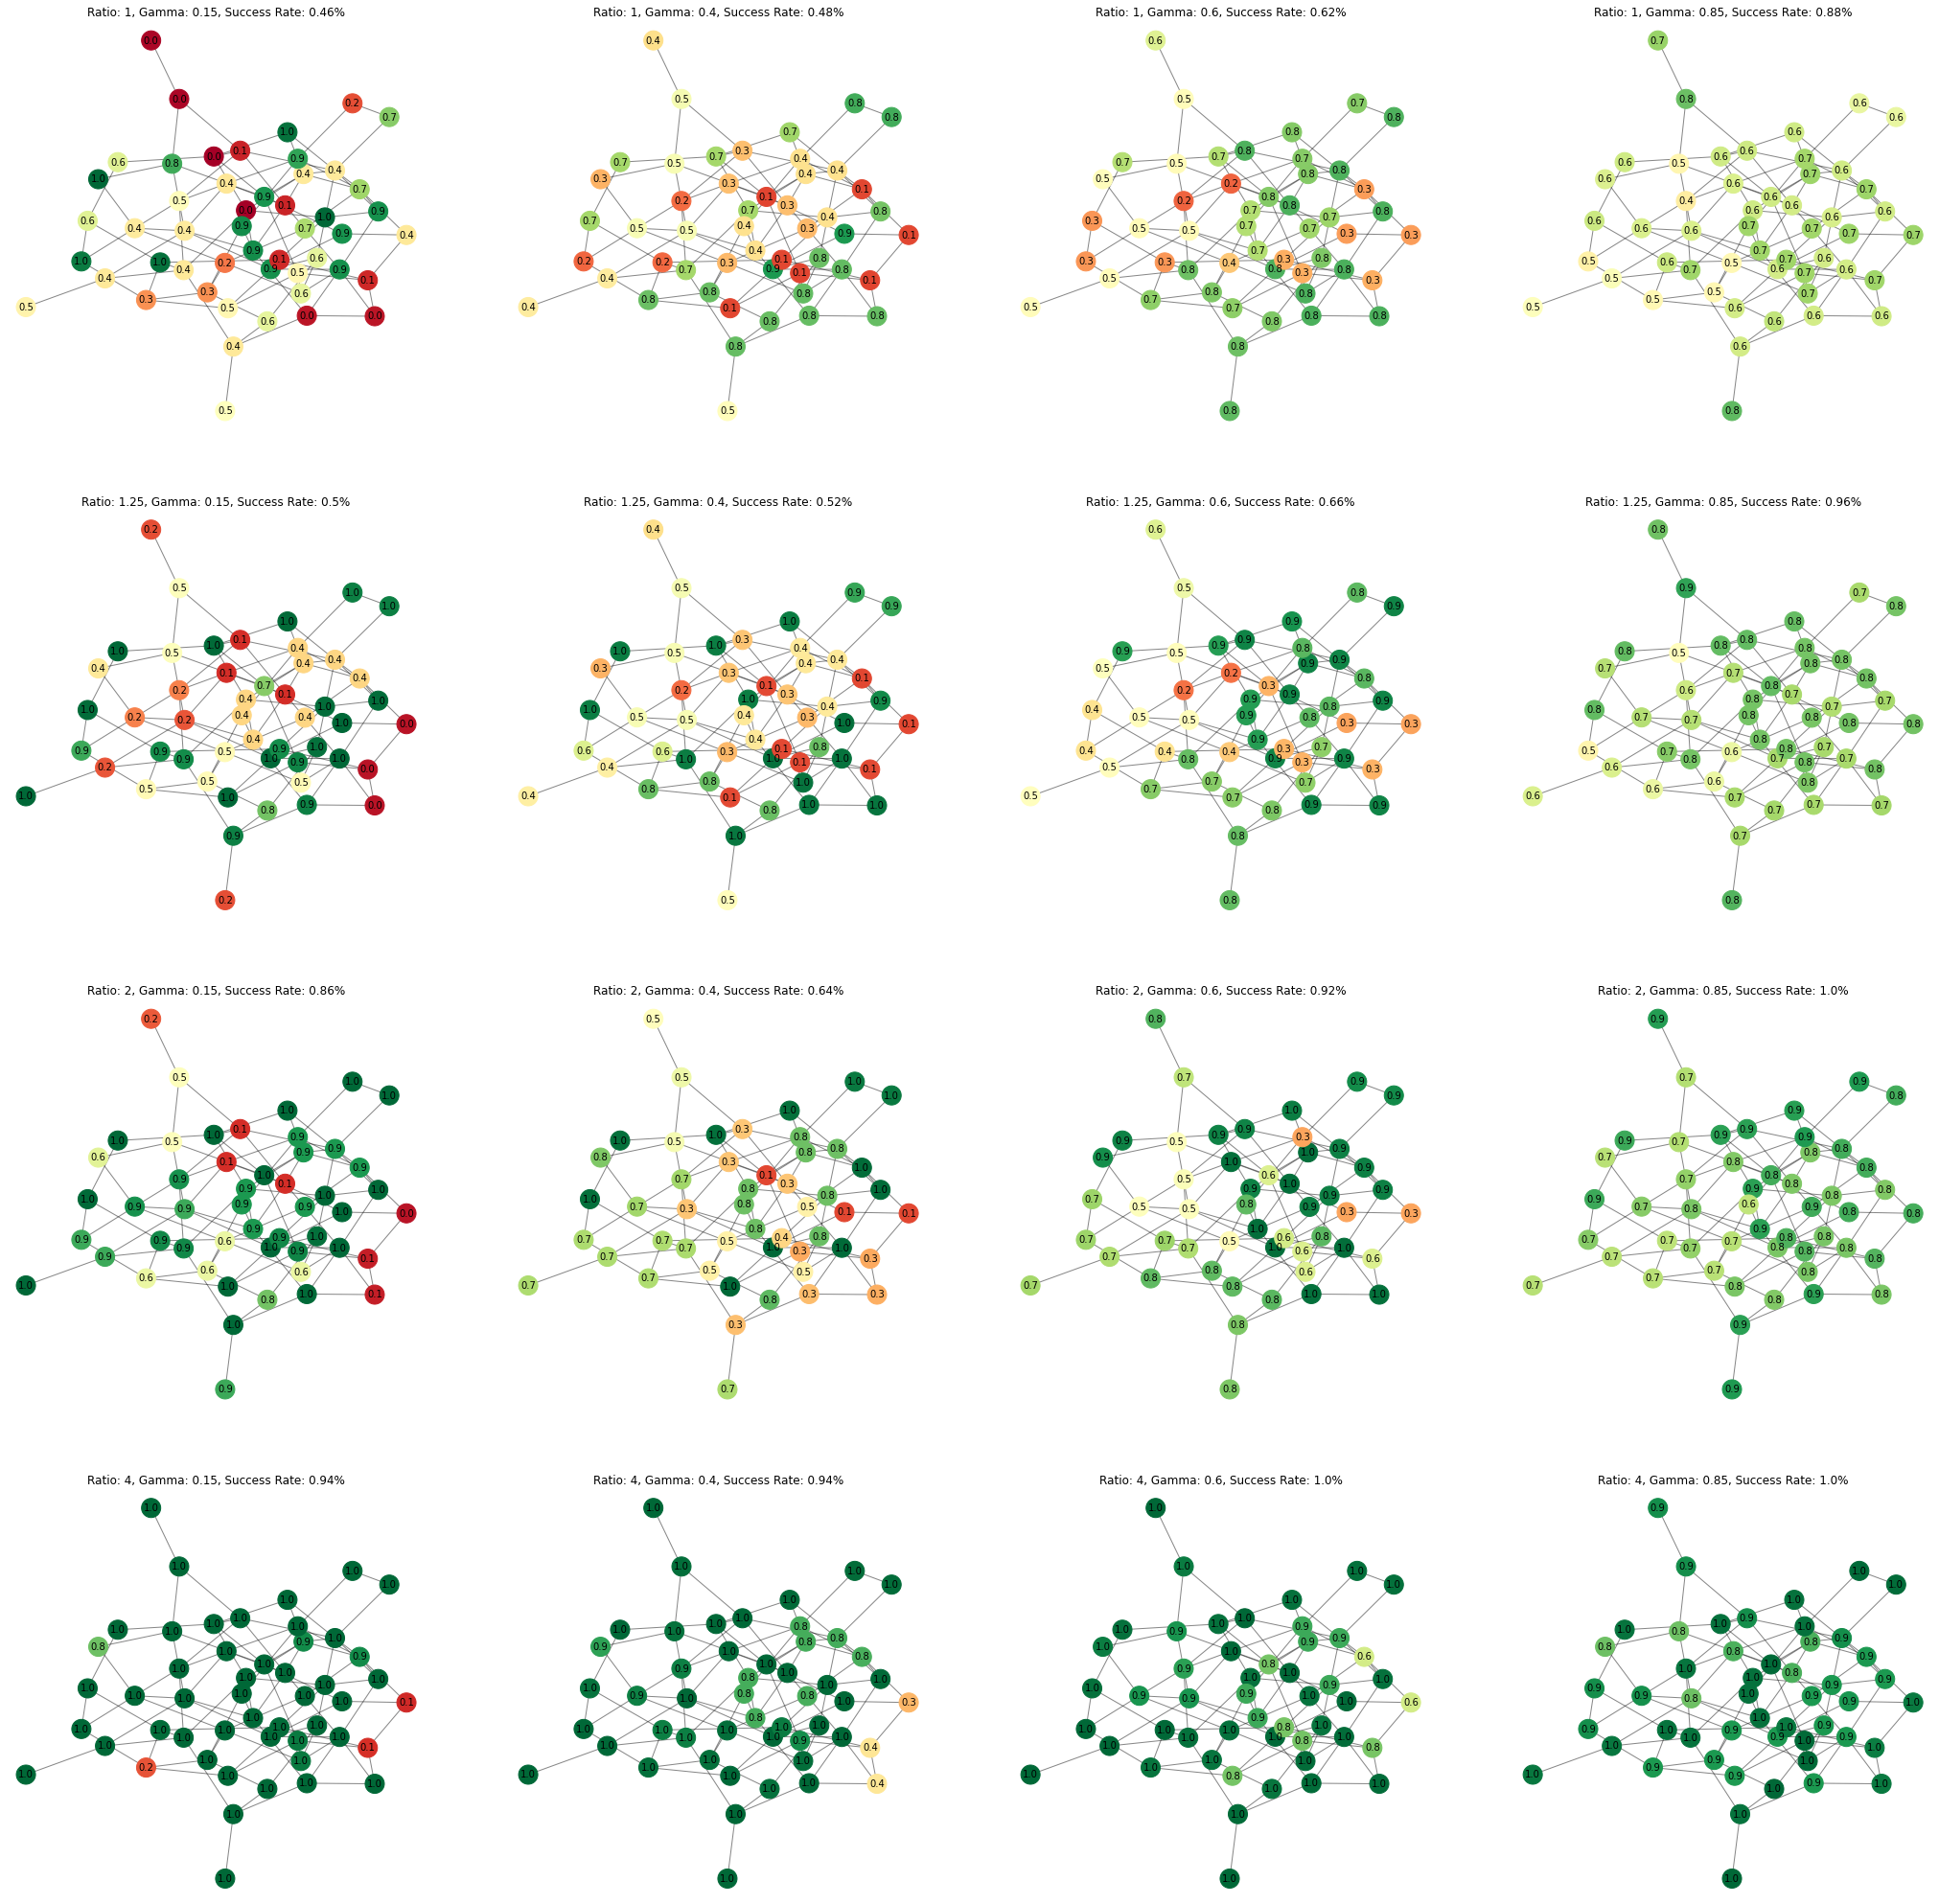

In [ ]:
gammas = [.15, .4, .6, .85]
ratios = [1, 1.25, 2, 4]
fig, axs = plt.subplots(len(ratios), len(gammas), figsize=(36, 36))
for i, r in enumerate(ratios):
    for j, g in enumerate(gammas):
        random.seed(246)
        G = create_graph(n, p)
        G = run_evolution(G, n_iter=200, p_node_0=.2, p_node_1=.2*r, 
                          p_edge=.2, gamma=g, verbose=False)
        np.random.seed(42)
        plot_graph(G, ax=axs[i,j]) 
        axs[i, j].set_title(f'Ratio: {r}, Gamma: {g}, Success Rate: {(np.array(extract_node_attribute(G, "o"))>=.5).mean()}%')
plt.draw()

From left to right there are graphs with individual more open minded and prone to change opinion, from top to bottom there is an increase in $Ratio$ with a costant $prob_0=0.20$.

### Plot the opinion distributions

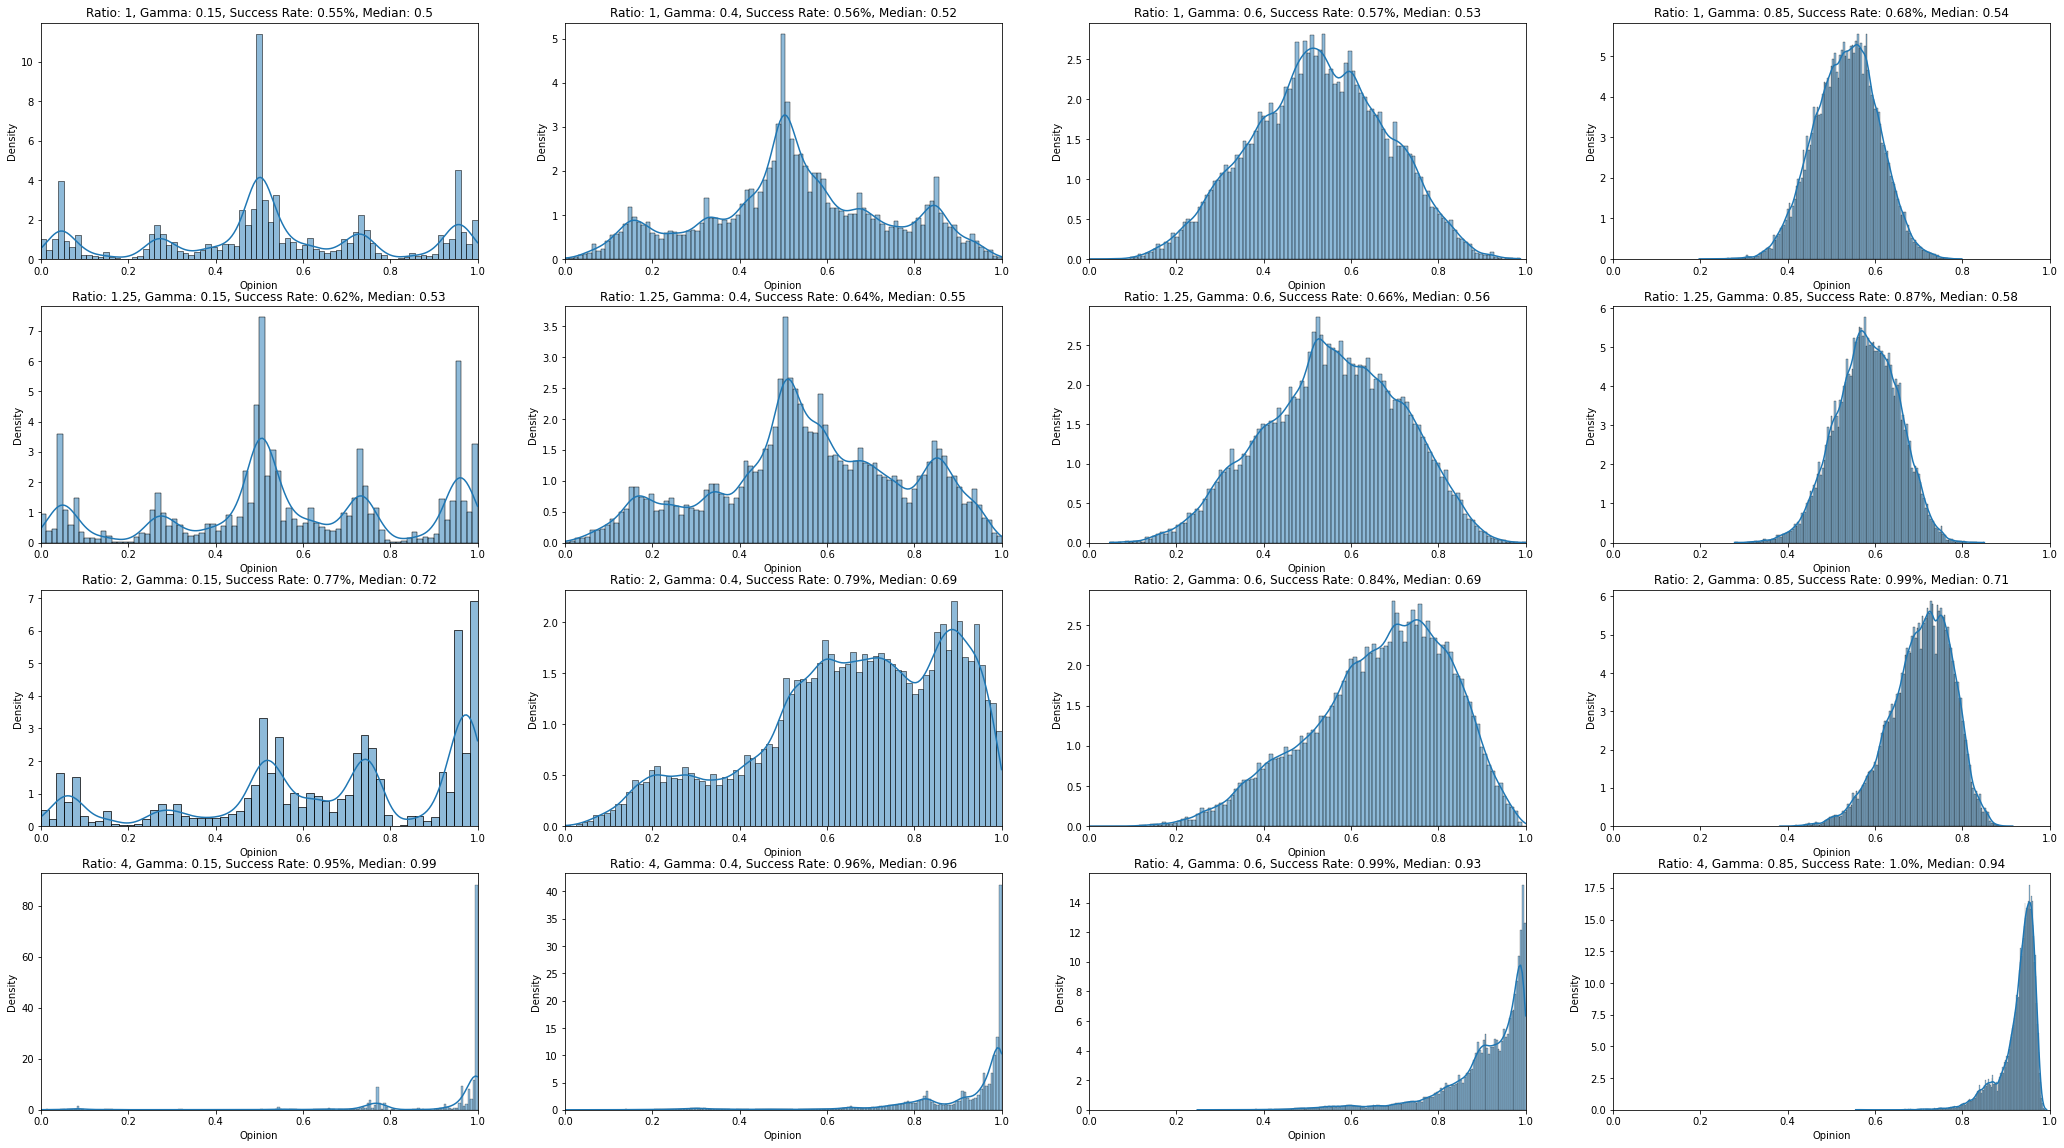

In [ ]:
gammas = [.15, .4, .6, .85]
# gammas = [.15, .4]
ratios = [1, 1.25, 2, 4]
# ratios = [1, 1.25]
fig, axs = plt.subplots(len(ratios), len(gammas), figsize=(36, 20))
for i, r in enumerate(ratios):
    for j, g in enumerate(gammas):
        np.random.seed(42)
        random.seed(246)
        df = extract_info_from_multiple_simulation(n_sim, n_nodes, p,
                                                   p_node_0=.2, p_node_1=.2*r, 
                                                   p_edge=.2, gamma=g, verbose=False)
        sns.histplot(data=df, x='o', stat='density', kde=True, ax=axs[i,j], fill=True)
        # axs[i, j].hist(df['o'], bins=100)
        axs[i, j].set_title(f'Ratio: {r}, Gamma: {g}, Success Rate: {np.round((df["o"] > 0.5).mean(), 2)}%, Median: {np.round(df["o"].median(), 2)}')
        axs[i, j].set_xlabel('Opinion', size=12)
        axs[i, j].set_xlim(0, 1)
plt.draw()

From left to right there are the simulation in which the people are more open minded, from to bottom the simulation with an higher ratio between the people reached by $s_1$ and $s_0$

### Considerations
It's shown that $\gamma$ acts as a smoother for the distribution, higher the $\gamma$ broader the distribution is. We saw a pro and a con: an high value of $\gamma$ increases the **Success Rate** (calculated as ratio percentage of nodes with an opinion's value greater than a given threshold $thresh = 0.5$) while degrades the median, this means that more people have a posivite opinion on the topic but less people have extreme opinions ($o\sim1$), in other words, **open-mindedness makes people skeptic.**

The $Ratio$, on the other hand, generates a shift of the distribution towards higher values ($o\to1$).

Please notice that, in presence of low $\gamma$, even with high value of $Ratio$ the **Success Rate** is not able to reach values around $100\%$ due to:
* the power of the source $s_0$ to affect people;
* the *close-mindedness* of some individuals.

## Analyze the influence of other people
Until now we fixed the probability that an edge is selected to $prob = 0.20$, now we analyze how the results change according to this parameters.

To do so we need to fix the other parameters. In absence of real world data we set the following parameters using the results obtained before and some personal assomption:
* $prob_0 = 0.2$
* $Ratio = 4$
* $\gamma = 0.3$

### Plot the evolution of small graphs

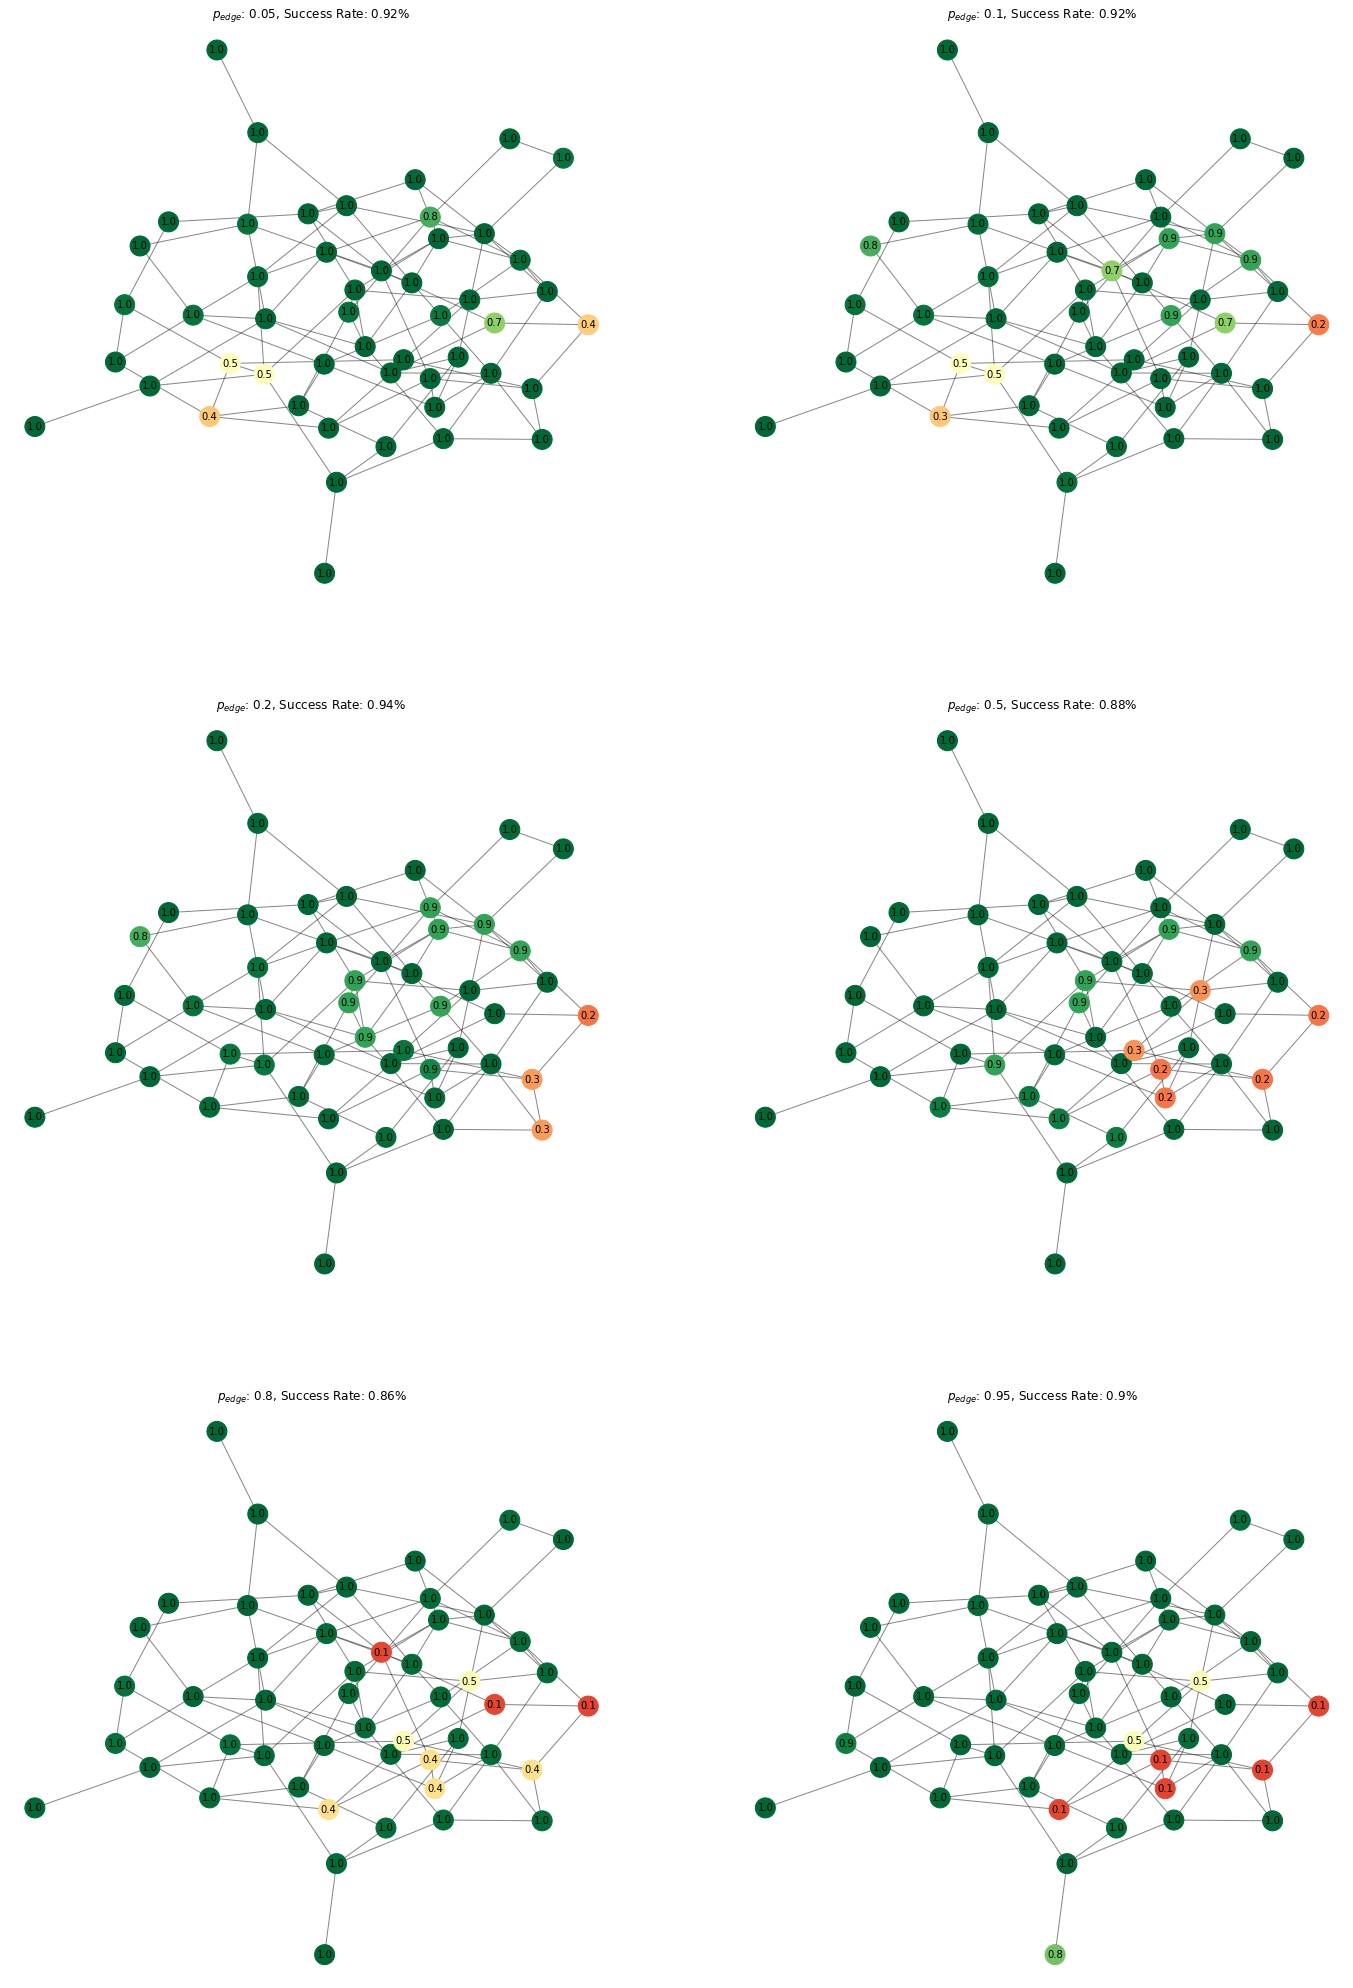

In [ ]:
p_0 = 0.2
ratio = 4
gamma = 0.3
p_edges = [.05, .1, .2, .5, .8, .95]
fig, axs = plt.subplots(len(p_edges)//2, 2, figsize=(24, 36))
for i, p_e in enumerate(p_edges):
        random.seed(246)
        G = create_graph(n, p)
        G = run_evolution(G, n_iter=200, p_node_0=p_0, p_node_1=p_0*ratio, 
                          p_edge=p_e, gamma=gamma, verbose=False)
        np.random.seed(42)
        plot_graph(G, ax=axs[i//2, i%2]) 
        axs[i//2, i%2].set_title('$p_{edge}$' + f': {p_e}, Success Rate: {(np.array(extract_node_attribute(G, "o"))>=.5).mean()}%')
plt.draw()

### Plot the opinion distributions

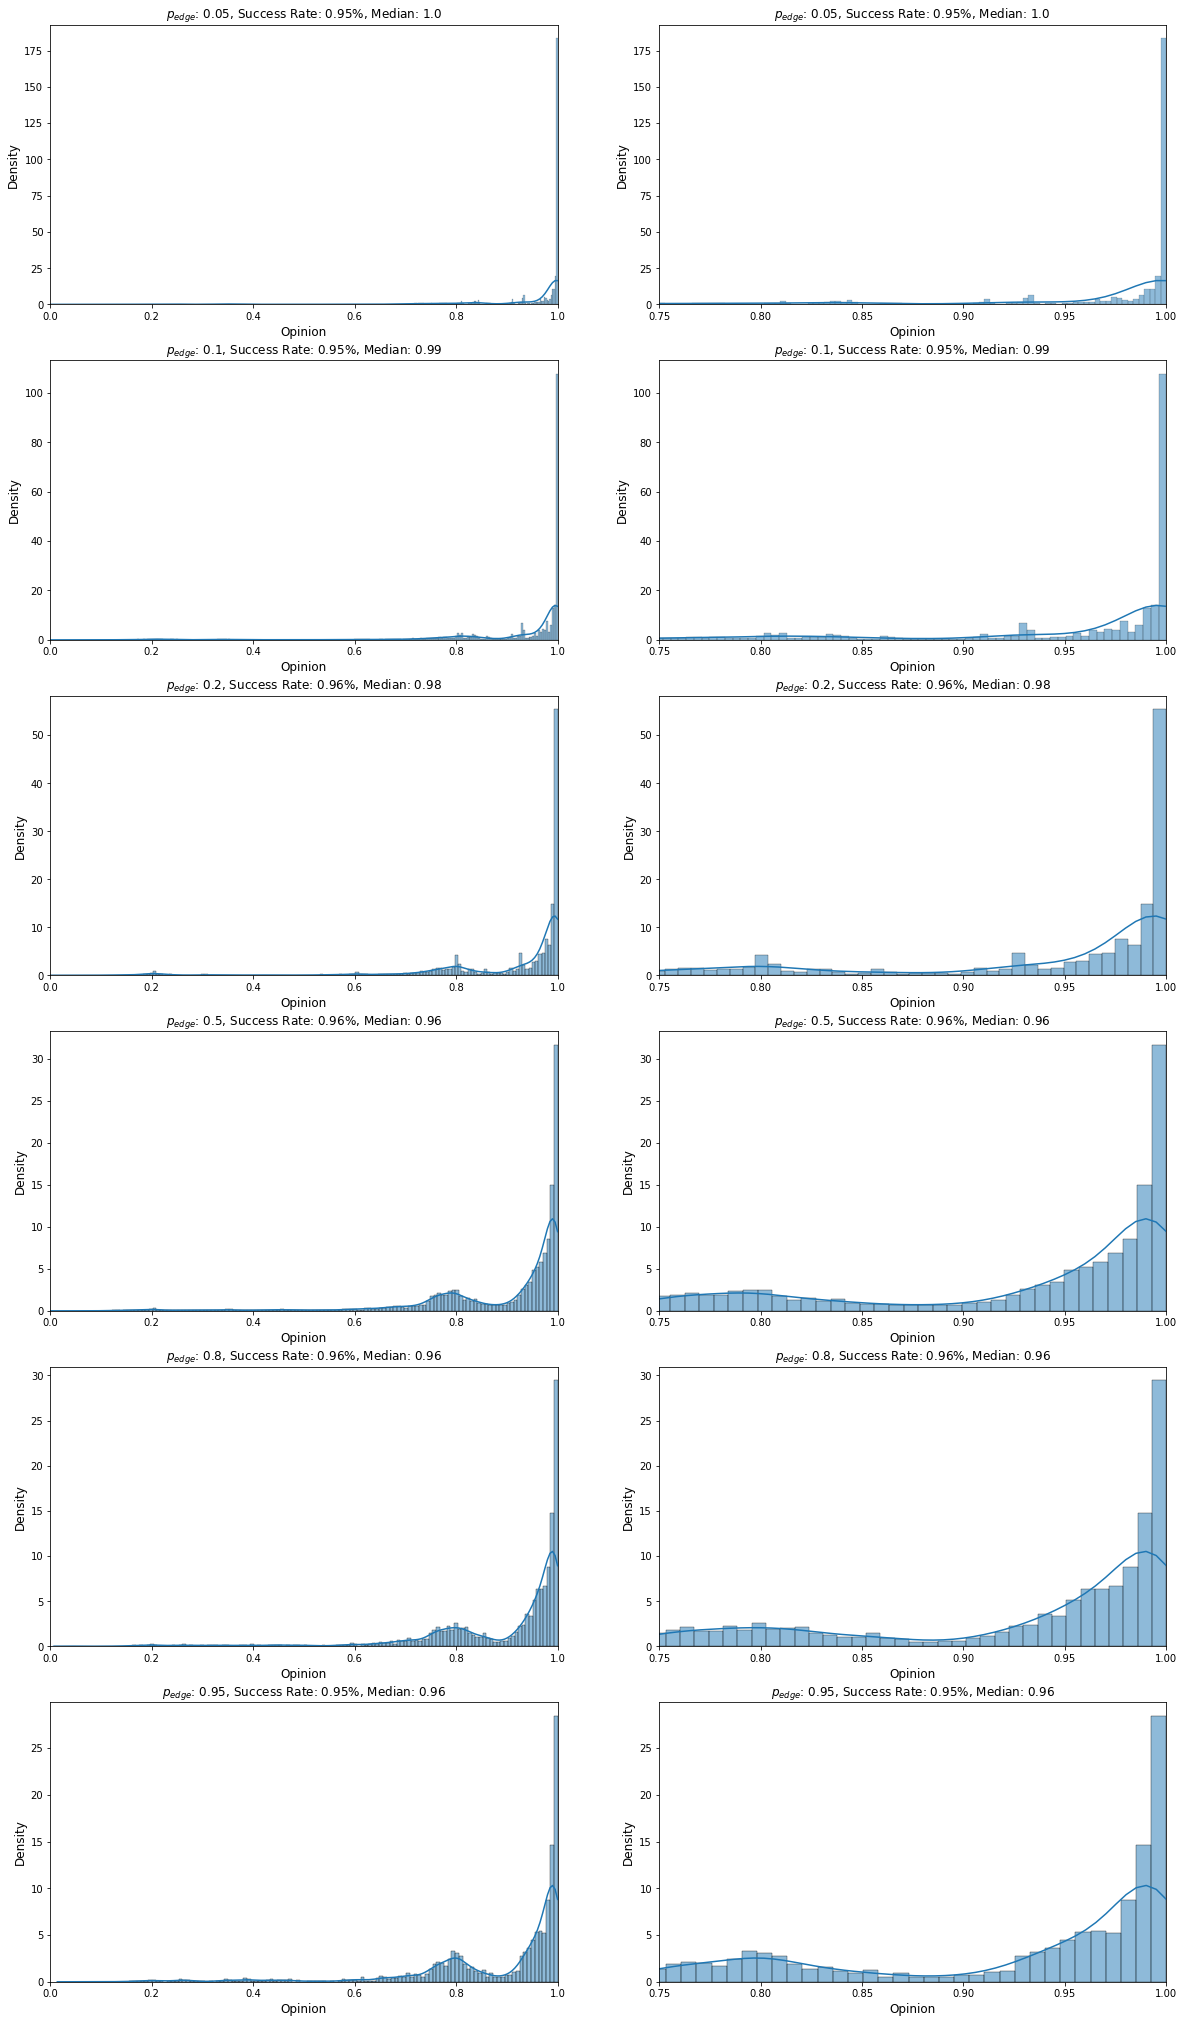

In [ ]:
p_0 = 0.2
ratio = 4
gamma = 0.3
p_edges = [.05, .1, .2, .5, .8, .95]
fig, axs = plt.subplots(len(p_edges), 2, figsize=(20, 36))
for i, p_e in tqdm(enumerate(p_edges)):
        np.random.seed(42)
        random.seed(246)
        df = extract_info_from_multiple_simulation(n_sim, n_nodes, p,
                                                   p_node_0=p_0, p_node_1=p_0*ratio, 
                                                   p_edge=p_e, gamma=gamma, verbose=False)
        
        sns.histplot(data=df, x='o', stat='density', kde=True, ax=axs[i, 0], fill=True)
        axs[i, 0].set_title('$p_{edge}$' + f': {p_e}, Success Rate: {np.round((df["o"] > 0.5).mean(), 2)}%, Median: {np.round(df["o"].median(), 2)}')
        axs[i, 0].set_xlabel('Opinion', size=12)
        axs[i, 0].set_ylabel('Density', size=12)
        axs[i, 0].set_xlim(0, 1)

        sns.histplot(data=df, x='o', stat='density', kde=True, ax=axs[i, 1], fill=True)
        axs[i, 1].set_title('$p_{edge}$' + f': {p_e}, Success Rate: {np.round((df["o"] > 0.5).mean(), 2)}%, Median: {np.round(df["o"].median(), 2)}')
        axs[i, 1].set_xlabel('Opinion', size=12)
        axs[i, 1].set_ylabel('Density', size=12)
        axs[i, 1].set_xlim(0.75, 1)
plt.show()


### Run the simulation

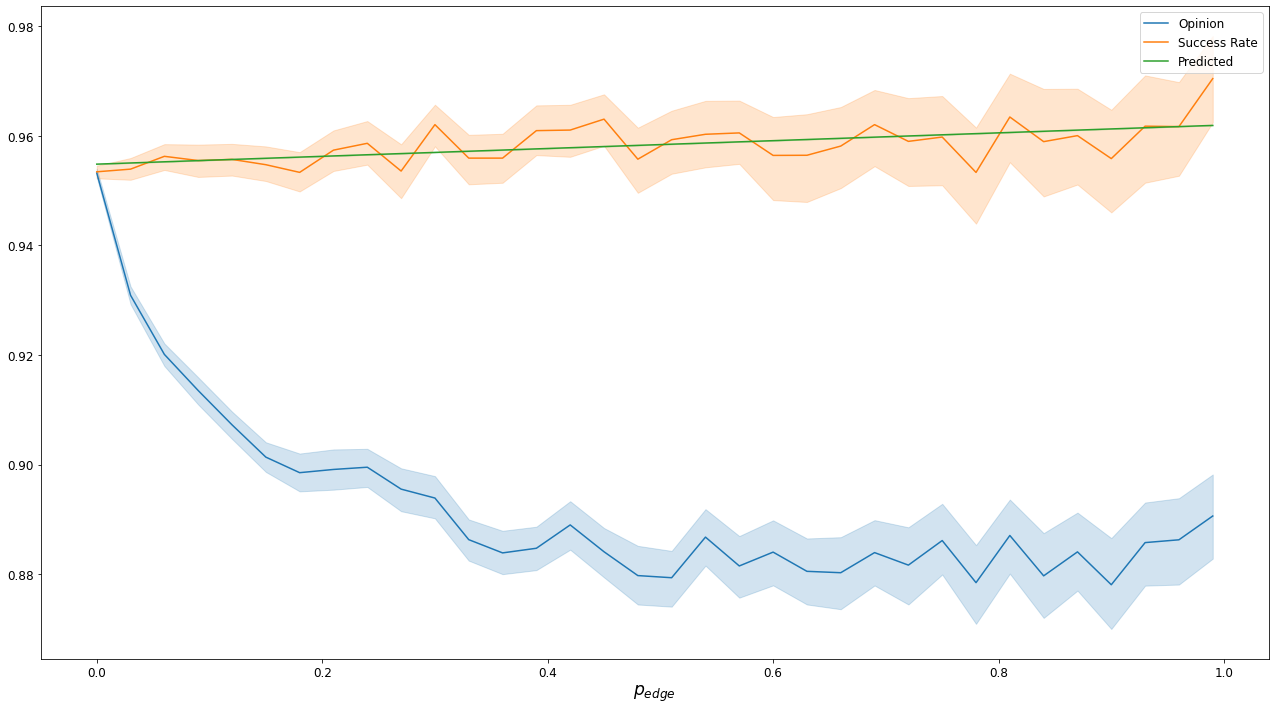

In [7]:
p_0 = 0.2
ratio = 4
gamma = 0.3
dfs = []
for p_e in tqdm(np.arange(0, 1, .03)):
    dfs.append(extract_info_from_multiple_simulation(n_sim, n_nodes, p,
                                                     p_node_0=p_0, p_node_1=p_0*ratio, 
                                                     p_edge=p_e, gamma=gamma, verbose=False))
df = pd.concat(dfs)
df['Success Rate'] = df['o'] >= 0.5

train_df = df.groupby('p_edge')['Success Rate'].mean().reset_index()
X = train_df[['p_edge']].values
y = train_df['Success Rate']
model = LinearRegression().fit(X, y)

grouped_df = df.rename(columns={'o': 'Opinion'}).groupby(['p_edge', 'idx'])[['Opinion', 'Success Rate']].mean().reset_index().copy()
grouped_df['Predicted'] = model.predict(grouped_df['p_edge'].values.reshape((-1, 1)))
melted_df = grouped_df.melt(['p_edge', 'idx'])

fig, ax = plt.subplots(figsize=(22,12))
sns.lineplot(data=melted_df, x='p_edge', y='value', hue='variable')
plt.xlabel('$p_{edge}$', size='xx-large')
plt.ylabel('')
plt.legend(fontsize='large')
plt.tick_params('both', labelsize='large')
plt.show()

In [8]:
Math('Model \\rightarrow f(p_{edge}) = m * p_{edge} + q = ' + str(round(model.coef_[0], 3)) + '* p_{edge} + ' + str(round(model.intercept_, 3)))

<IPython.core.display.Math object>

### Considerations
Similarly to what the $\gamma$ does an increase in the $p_{edge}$ parameter makes the the opinion distributions broader but, unlike the first, the latter it isn't correlated with the **Success Rate**. 

To show this in the figure above we plotted the prediction of a linear model that, given $p_{edge}$, should be able to predict the **Success Rate**. The model found that the steepness of the line is $\sim0.007$ therefore we can say that the value of $p_{edge}$ is negligible for the evaluation of the **Success Rate**.



In [ ]:
grouped_df[['p_edge', 'Success Rate']].corr()

,p_edge,Success Rate
p_edge,1.000000,0.027913
Success Rate,0.027913,1.000000


Another measure to prove the uncorrelation between $p_{edge}$ and the **Success Rate** is the *Pearson Correlation* which scores $\sim0.0028$. 

## Analyze the influence of the $Ratio$
We already shown the effect of the $Ratio$ parameter in conjuction with $\gamma$. Now we would like to analyze how it influences **Opinion** and **Success Rate**.

To do so we fix the follow parameters:
* $\gamma = 0.3$
* $p_{edge} = 0.2$

In [9]:
gamma = 0.3
p_e = 0.2
dfs = []
for ratio in tqdm(np.arange(1, 10.01, 0.25)):
    for p_0 in [0.01, 0.05, 0.1, 0.2]:
        dfs.append(extract_info_from_multiple_simulation(n_sim, n_nodes, p,
                                                         p_node_0=p_0, p_node_1=p_0*ratio, 
                                                         p_edge=p_e, gamma=gamma, verbose=False))
df = pd.concat(dfs)
df['Success Rate'] = df['o'] > 0.5
df['Ratio'] = df['p_node_1'] / df['p_node_0']

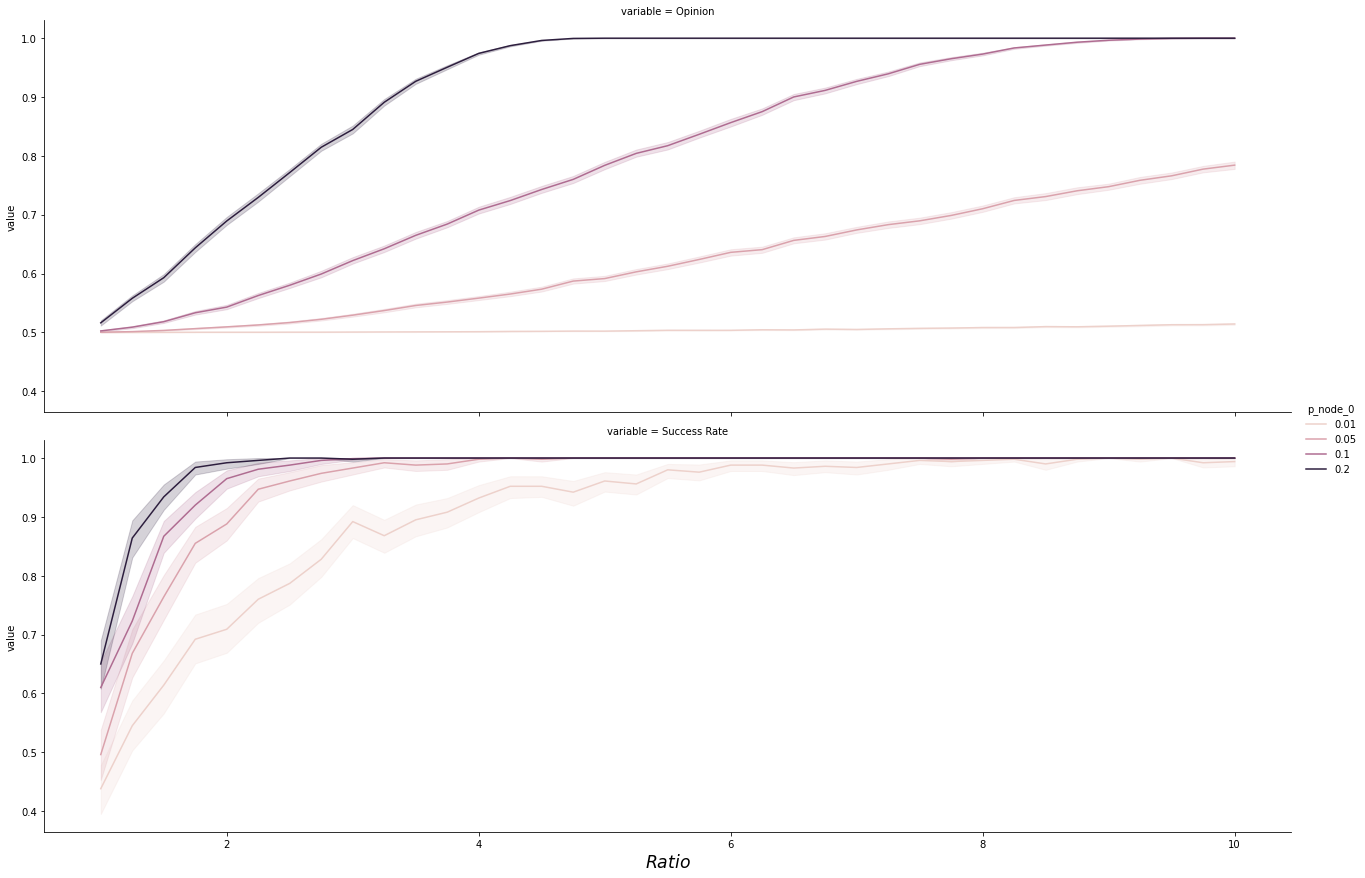

In [10]:
grouped_df = df.rename(columns={'o': 'Opinion'}).groupby(['Ratio', 'idx', 'p_node_0'])[['Opinion', 'Success Rate']].median().reset_index().copy()
melted_df = grouped_df.melt(['Ratio', 'idx', 'p_node_0'])

sns.relplot(data=melted_df, x='Ratio', y='value', hue='p_node_0', row='variable', kind='line', height=6, aspect=3)
plt.xlabel('$Ratio$', size='xx-large')
plt.show()

Above you can see the effect that an increasing $Ratio$ has the median **Opinion** and **Success Rate**, using different $p_0$. 

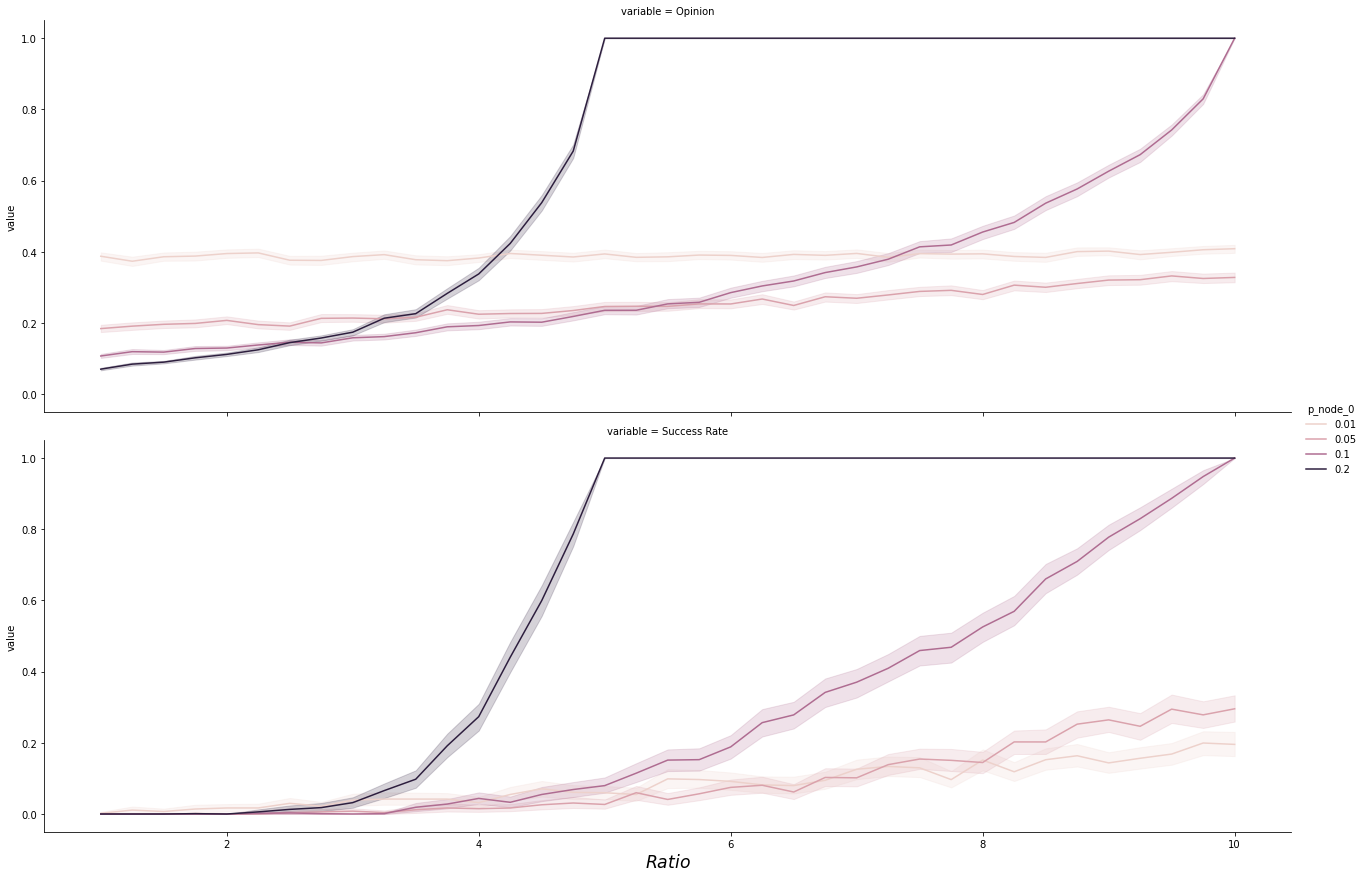

In [11]:
grouped_one_pct_q_df = df.rename(columns={'o': 'Opinion'}).groupby(['Ratio', 'idx', 'p_node_0'])[['Opinion', 'Success Rate']].apply(lambda x: x.aggregate(lambda x: np.quantile(x, .01), axis=0)).reset_index()
melted_one_pct_q_df = grouped_one_pct_q_df.melt(['Ratio', 'idx', 'p_node_0'])

sns.relplot(data=melted_one_pct_q_df, x='Ratio', y='value', hue='p_node_0', row='variable', kind='line', height=6, aspect=3)
plt.xlabel('$Ratio$', size='xx-large')
plt.show()

Above you can see the effect that an increasing $Ratio$ has the first percentile of **Opinion** and **Success Rate**, using different $p_0$. You can think this as the evolution of the worst case senario.

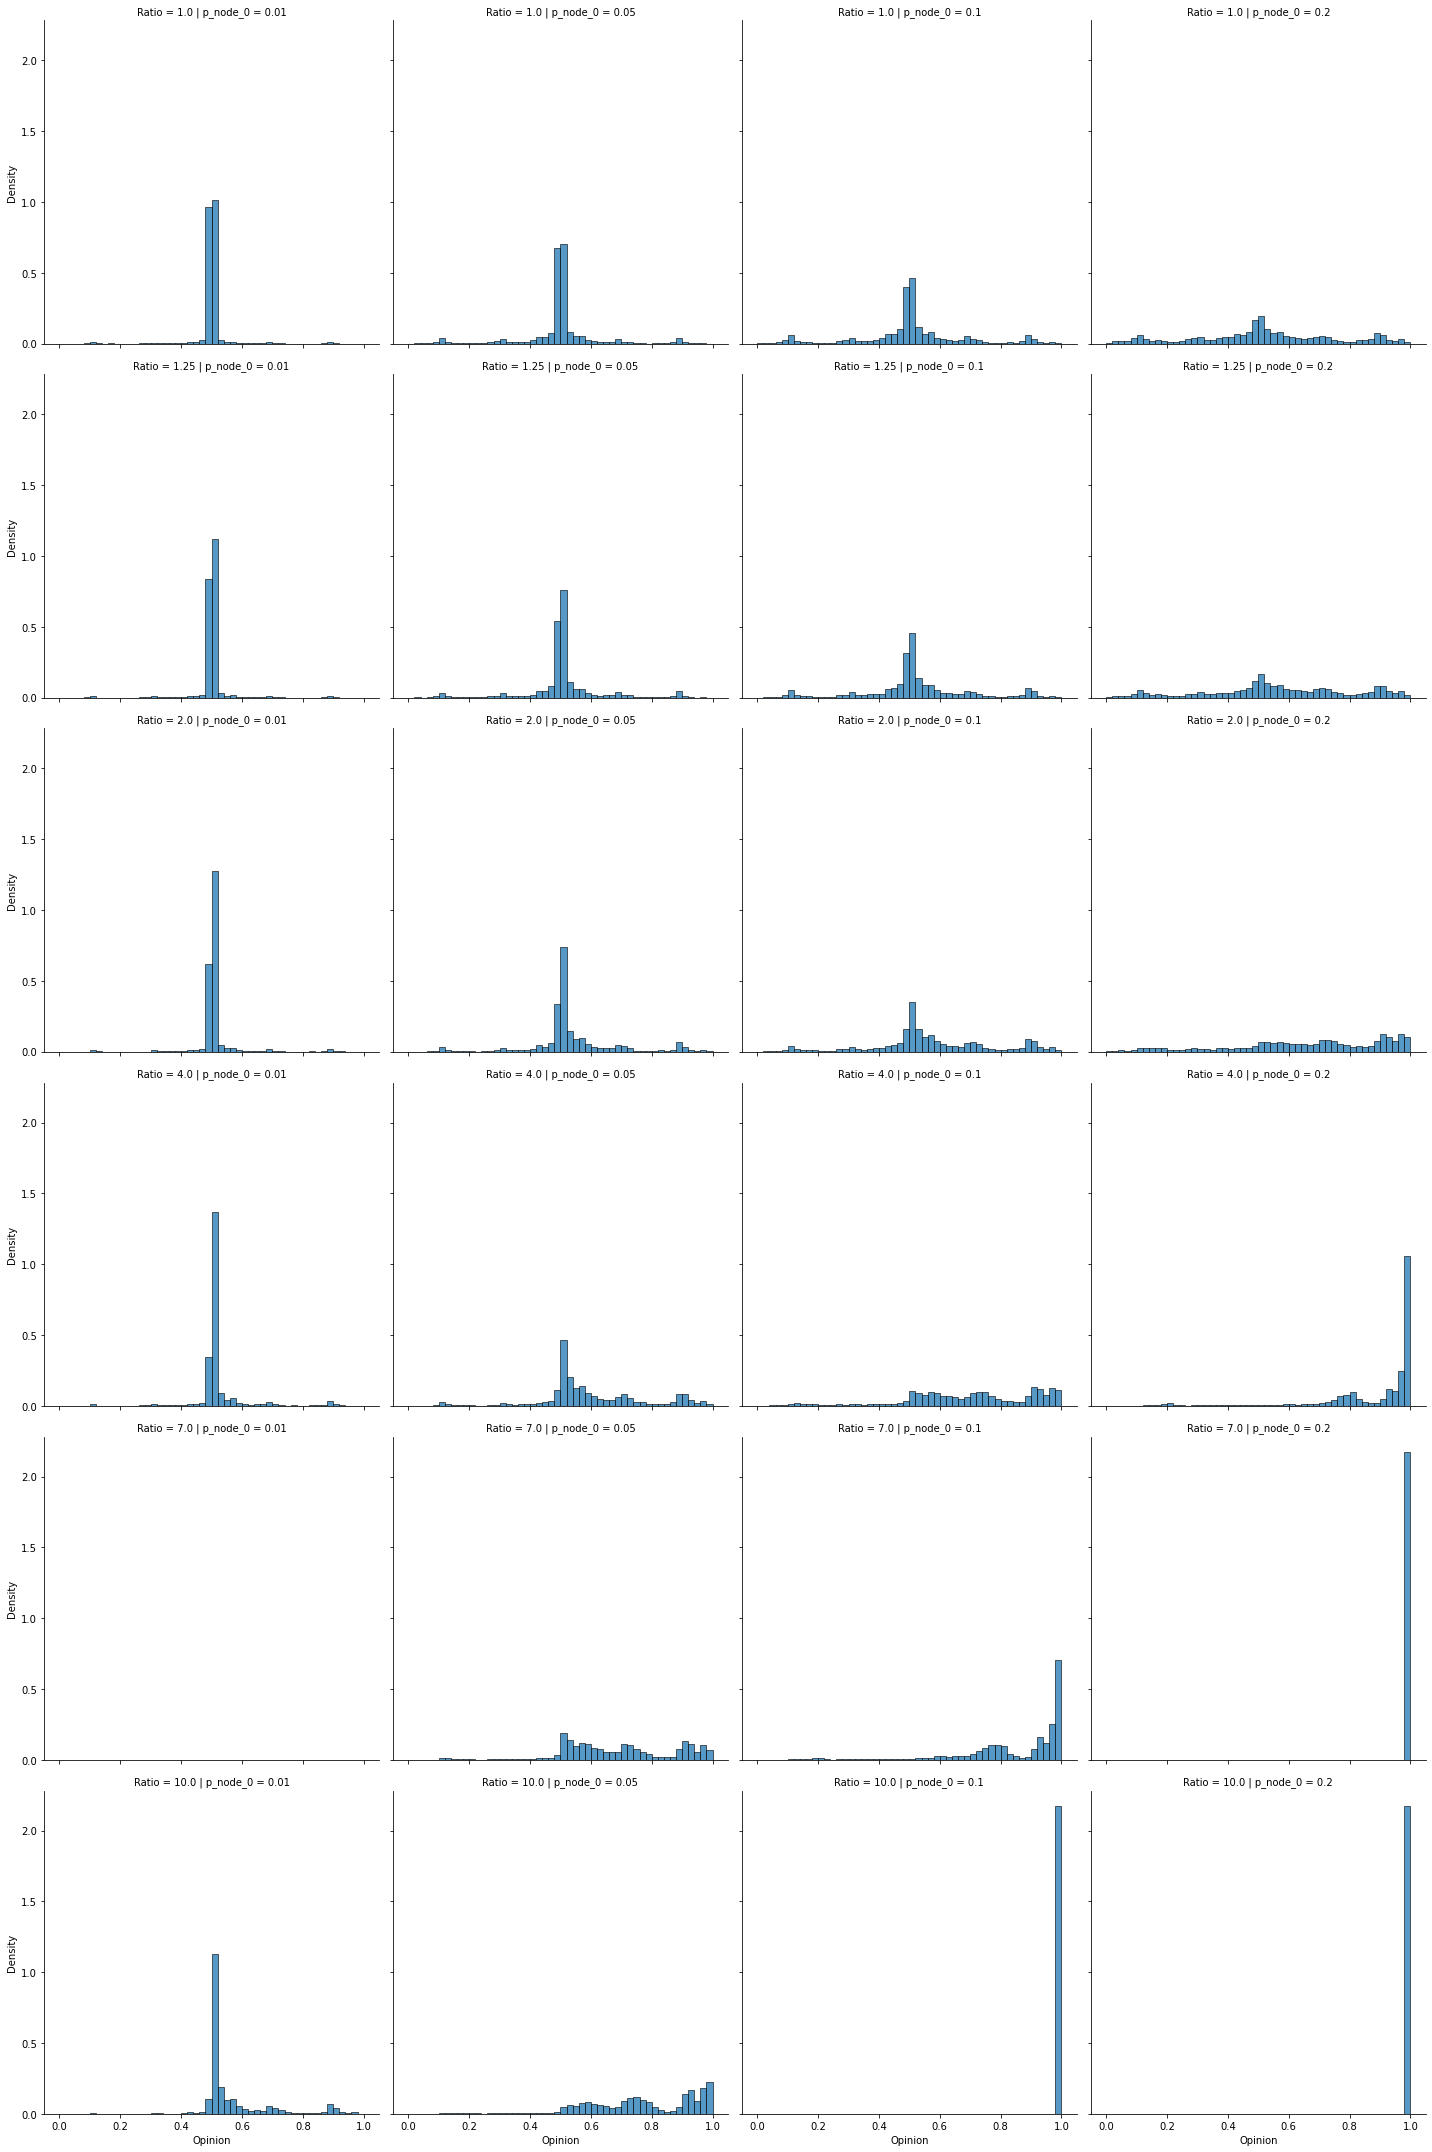

In [12]:
sns.displot(data=df[df.Ratio.isin([1, 1.25, 2, 4, 7, 10])].rename(columns={'o': 'Opinion'}), x='Opinion', row='Ratio', col='p_node_0', stat="density", bins=50)

### Considerations
For low levels of $p_0$ the resulting **Opinion** distribution is concentrated around $0.5$ even for high values of $Ratio$. This is due to the communication between nodes that keeps, on average, far from outer values.

We can interpret this saying that the society is an information source stronger than the others and therefore it prevents the individual's polarization.